  0%|          | 0/7 [00:00<?, ?it/s]

δ =  0.5
True chgpts = 200


  0%|          | 0/10 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:16<01:39, 16.65s/it]

δ =  0.75
True chgpts = 300


  0%|          | 0/10 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:35<01:29, 17.97s/it]

δ =  1.0
True chgpts = 400


  0%|          | 0/10 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:57<01:18, 19.74s/it]

δ =  1.25
True chgpts = 500


  0%|          | 0/10 [00:00<?, ?it/s]

 57%|█████▋    | 4/7 [01:22<01:05, 21.83s/it]

δ =  1.5
True chgpts = 600


  0%|          | 0/10 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [01:51<00:48, 24.31s/it]

δ =  1.75
True chgpts = 700


  0%|          | 0/10 [00:00<?, ?it/s]

 86%|████████▌ | 6/7 [02:23<00:27, 27.09s/it]

δ =  2.0
True chgpts = 800


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 7/7 [02:58<00:00, 25.52s/it]


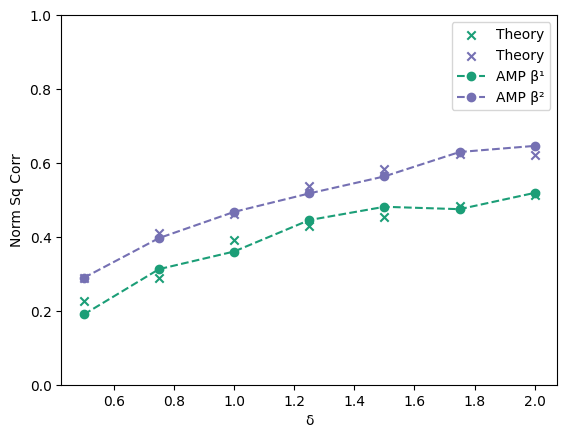

In [1]:
import numpy as np
import jax.numpy as jnp # Not used in any randomness, all randomness is in numpy
import jax
import numpy.random as nprandom
import matplotlib.pyplot as plt
from amp import MSE, norm_sq_corr, PAL, hausdorff
from amp.marginal_separable_jax import q, GAMP_full, SE_fixed_C_v1, GAMP_gaussian_clean, SE_fixed_C, GAMP
import amp.marginal_separable_jax
import amp.changepoint_jax as changepoint_jax
import amp.signal_configuration
from amp.signal_configuration import C_to_chgpt, generate_C_distanced, unif_prior_to_η_ϕ
from amp.signal_priors import SignalPrior, SparseDiffSignal, SparseGaussianSignal, GaussianSignal
from amp.posterior import MAP, MAP_η, compute_posterior, posterior_over_η, η_to_ψ
from amp.marginal_separable_jax import GAMP_gaussian_clean, GAMP_real_data, q
from amp.signal_priors import GaussianSignal
from functools import partial
from tqdm import tqdm
import scipy
tqdm = partial(tqdm, position=0, leave=True)

# np.random.seed(1)

p = 1000
σ = 0.4 # noise standard deviation
L = 2 # num signals. L-1 changepoints

T = 10 # num_iterations
num_trials = 15
δ_list = [0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]

chgpt_location = 0.4

corr_1_list = []
corr_2_list = []
corr_1_SE_list = []
corr_2_SE_list = []
post_list = []


for i in tqdm(range(len(δ_list))):
    δ = δ_list[i]
    print("δ = ", δ)

    n = int(δ * p)
    true_chgpt_locations = lambda n: int(n*chgpt_location)

    # --- Preliminaries ---
    # Changepoint locations
    Δ = lambda n: int(n/10)
    Lmin = 2
    Lmax = 2
    num_valid_configs, η_arr, p_η_arr, ϕ = unif_prior_to_η_ϕ(Lmin, Lmax, Δ(n), n) # Lxn matrix
    assert η_arr.shape == (num_valid_configs, Lmax-1) and \
        len(p_η_arr) == num_valid_configs
    assert ϕ.shape == (Lmax, n)

    print(f"True chgpts = {true_chgpt_locations(n)}")
    C_true = η_to_ψ(np.array([true_chgpt_locations(n)]), n)

    # Gaussian Signal Prior
    B̃_cov = np.eye(L)
    B̃_cov[0, 1] = 0.5
    B̃_cov[1, 0] = 0.5
    signal_prior = GaussianSignal(B̃_cov)

    # Sparse Gaussian Signal Prior
    # α = 0.6 # fraction of nonzeros
    # σ_l_arr = np.array([0.5, 0.5]) # signal standard deviation
    # signal_prior = SparseGaussianSignal(α, δ, σ_l_arr)

    # Sparse Difference Signal Prior
    # α = 0.25 # fraction of nonzeros
    # # σ_l_arr = np.array([2.5, 2.5]) # signal standard deviation
    # var_β_1 = 1
    # σ_w = 1
    # signal_prior = SparseDiffSignal(var_β_1, σ_w, α, L)

    # Soft threshold denoiser 
    # σ_l_arr = np.array([2.5, 2.5]) # signal standard deviation
    # α = 0.5 # fraction of nonzeros
    # signal_prior = SparseGaussianSignal(α, δ, σ_l_arr)
    # st_ζ = 0.5 # The scaling factor in front of the effective noise std in the threshold
    # if soft thresholding. Setting st_ζ != None in the GAMP_full function.

    B̃ = signal_prior.sample(p)
    B̂_0 = signal_prior.sample(p)

    # ρ = 1/δ * B̃_cov # 1/δ * Covariance matrix of each row of B_0, independent for now but should be generalized later
    ρ = 1/δ * 1/p * B̃.T @ B̃

    # Generate a covariance matrix
    # Identity covariance
    Σ = np.eye(p)
    # Generate a reasonable covariance matrix
    # Σ = np.zeros((p, p))
    # for i in range(p):
    #     for j in range(p):
    #         Σ[i, j] = 0.5 ** (np.abs(i - j))
    # Another random covariance construction: 
    # A = np.random.rand(p, p)
    # Σ = np.dot(A, A.transpose())

    L_chol = scipy.linalg.cholesky(Σ, lower = True)
    #Σ = L_chol @ L_chol.T

    # Generate the observation vector Y
    # X = np.random.normal(0, np.sqrt(1/n), (n, p))
    X = np.random.normal(0, np.sqrt(1/n), (n, p)) @ L_chol.T
    Θ = X @ B̃
    Y = q(Θ, C_true, σ) 

    B̂, Θ_t, ν_arr, κ_T_arr, ν̂_arr, κ_B_arr, ν_fixed_arr, κ_T_fixed_arr, ν̂_fixed_arr, κ_B_fixed_arr = GAMP_full(B̃, δ, p, ϕ, σ, X, Y, C_true, T, B̂_0, signal_prior, signal_prior, st_ζ = None, verbose = False, seed = None, tqdm_disable = False)
    # B̂, Θ_t, ν_arr, κ_T_arr, ν̂_arr, κ_B_arr = GAMP(B̃, δ, p, ϕ, σ, X, Y, T, true_signal_prior=signal_prior, est_signal_prior=signal_prior)
    ν = ν_arr[-1]
    κ_T = κ_T_arr[-1]
    ν_fixed = ν_fixed_arr[-1]
    κ_T_fixed = κ_T_fixed_arr[-1]

    # (δ * ρ[1, 1] - δ * ν_arr[-1, 1, 1]) + (δ * ρ[0, 0] - δ * ν_arr[-1, 0, 0]) - 2*(δ * ρ[0, 1] - δ * ν_arr[-1, 0, 1])
    # ν_fixed, κ_T_fixed = SE_fixed_C(C_true, signal_prior, signal_prior, δ, p, ϕ, L, σ, T, tqdm_disable = False, st_ζ=None)

    corr_1_list.append(norm_sq_corr(B̂[:, 0], B̃[:, 0]))
    corr_2_list.append(norm_sq_corr(B̂[:, 1], B̃[:, 1]))
    corr_1_SE_list.append(ν_fixed[0, 0]**2 / ( ρ[0, 0] * (κ_T_fixed + ν_fixed.T @ np.linalg.inv(ρ) @ ν_fixed)[0, 0]))
    corr_2_SE_list.append(ν_fixed[1, 1]**2 / ( ρ[1, 1] * (κ_T_fixed + ν_fixed.T @ np.linalg.inv(ρ) @ ν_fixed)[1, 1]))

    ## Run Lasso for comparison
    # lasso_cv = linear_model.LassoCV(cv=5, n_jobs=2, tol=1e-5)
    # lasso_cv.fit(A, y)
    # lasso = linear_model.Lasso(alpha=lasso_cv.alpha_, tol=1e-12, max_iter=int(1e5))
    # lasso.fit(A, y)

    ## Compute posterior
    post = amp.posterior.posterior_over_η(η_arr, p_η_arr, Θ_t, Y, ρ, σ, ν, κ_T)
    post_list.append(post)

# Sqcorr plots
plt.errorbar(δ_list, (corr_1_list), label="AMP β¹", marker="o", ls="--", c=PAL[0], alpha = 1.0)
plt.errorbar(δ_list, (corr_2_list), label="AMP β²", marker="o", ls="--", c=PAL[2], alpha = 1.0)
plt.scatter(δ_list,corr_1_SE_list, label="Theory", marker="x", alpha = 1.0, c=PAL[0])
plt.scatter(δ_list, corr_2_SE_list, label="Theory", marker="x", alpha = 1.0, c=PAL[2])
plt.ylim((0, 1))
plt.xlabel("δ")
plt.ylabel("Norm Sq Corr")
plt.legend()
plt.show()

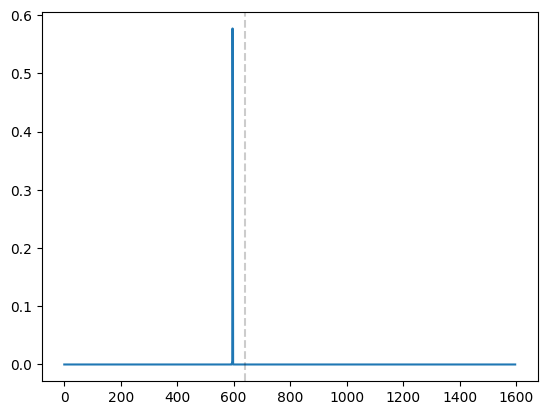

In [13]:
i = 6
plt.plot(post_list[i], label="δ = 0.5")
# Vertical line at true change point location, 0.4 fractional distance
plt.axvline(x=(0.4)*len(post_list[i]), color='k', linestyle='--', alpha = 0.2)